In [1]:
import io, sys, os, math, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt

In [2]:
# 1) Load CSV

from google.colab import files
print("Upload your dataset CSV (e.g., melanoma_clinical_imbalanced.csv)")
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]

df = pd.read_csv(csv_path)

Upload your dataset CSV (e.g., melanoma_clinical_imbalanced.csv)


Saving melanoma_clinical_imbalanced.csv to melanoma_clinical_imbalanced.csv


In [3]:
# 2) Detect label column (or override)
# -----------------------------
LABEL_OVERRIDE = None  # e.g., 'label' or 'target'. Set this if auto-detect guesses wrong.

def guess_label_column(dataframe):
    # Prefer last column if binary-like
    last = dataframe.columns[-1]
    def is_binary(col):
        vals = pd.Series(dataframe[col].dropna().unique())
        return len(vals) == 2 or set(vals.astype(str)).issubset({'0','1','True','False','true','false'})
    if is_binary(last):
        return last

    # Else search for a binary-ish column
    candidates = []
    for c in dataframe.columns:
        if dataframe[c].nunique() == 2:
            candidates.append(c)
    if candidates:
        return candidates[-1]  # choose last binary column

    # Fallback: try common names
    common = ['label','target','class','outcome','diagnosis','y']
    for c in common:
        if c in dataframe.columns:
            return c
    # As absolute fallback: last column
    return last

label_col = LABEL_OVERRIDE if LABEL_OVERRIDE else guess_label_column(df)
if label_col not in df.columns:
    raise ValueError(f"Label column '{label_col}' not found. Set LABEL_OVERRIDE to your label column name.")

# Ensure y is numeric {0,1}
y_raw = df[label_col]
if y_raw.dtype == 'O':
    # Map the minority to 1 if possible; fallback lexicographic
    values = y_raw.dropna().unique().tolist()
    if len(values) != 2:
        raise ValueError(f"Detected label column '{label_col}' has {len(values)} classes; need binary.")
    # Try common malignant markers
    positive_aliases = {'malignant','cancer','yes','1','true','pos','positive'}
    if str(values[0]).lower() in positive_aliases:
        mapping = {values[0]:1, values[1]:0}
    elif str(values[1]).lower() in positive_aliases:
        mapping = {values[1]:1, values[0]:0}
    else:
        # default: second unique value -> 1
        mapping = {values[0]:0, values[1]:1}
    y = y_raw.map(mapping)
else:
    # If numeric but not {0,1}, map the larger mean to 1
    uniq = sorted(y_raw.dropna().unique().tolist())
    if len(uniq) != 2:
        raise ValueError(f"Detected label column '{label_col}' has {len(uniq)} classes; need binary.")
    # Map smallest to 0, largest to 1
    mapping = {uniq[0]:0, uniq[1]:1}
    y = y_raw.map(mapping)

X = df.drop(columns=[label_col])

In [4]:
# 3) Split features by type + preprocessing
# -----------------------------
cat_cols = [c for c in X.columns if X[c].dtype == 'O']
num_cols = [c for c in X.columns if X[c].dtype != 'O']

numeric_transformer = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

In [5]:
# 4) Define models
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight='balanced', n_jobs=None),
    "Random Forest": RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=42, n_jobs=-1),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


In [6]:
# 5) Stratified CV + metrics
# -----------------------------
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

records = []
oof_predictions = {}   # store out-of-fold preds for confusion matrices later
oof_probas = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocessor), ("clf", clf)])
    fold_metrics = []
    preds_all = np.zeros_like(y, dtype=int)
    probas_all = np.zeros(len(y), dtype=float)

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_te)

        # Probabilities for AUC (if available)
        if hasattr(pipe.named_steps["clf"], "predict_proba"):
            y_proba = pipe.predict_proba(X_te)[:,1]
        elif hasattr(pipe.named_steps["clf"], "decision_function"):
            # Scale decision function to 0-1 with min-max (monotonic; OK for AUC)
            dec = pipe.decision_function(X_te)
            mn, mx = dec.min(), dec.max()
            y_proba = (dec - mn) / (mx - mn + 1e-9)
        else:
            y_proba = y_pred.astype(float)

        # Per-fold metrics
        acc = accuracy_score(y_te, y_pred)
        prec = precision_score(y_te, y_pred, zero_division=0)
        rec = recall_score(y_te, y_pred, zero_division=0)
        spec = specificity_score(y_te, y_pred)
        f1 = f1_score(y_te, y_pred, zero_division=0)
        auc = roc_auc_score(y_te, y_proba) if len(np.unique(y_te)) == 2 else np.nan

        fold_metrics.append([acc, prec, rec, spec, f1, auc])

        preds_all[te_idx] = y_pred
        probas_all[te_idx] = y_proba

    fold_metrics = np.array(fold_metrics)
    means = fold_metrics.mean(axis=0)
    stds  = fold_metrics.std(axis=0)

    records.append({
        "Model": name,
        "Accuracy (%)": f"{means[0]*100:.2f} ± {stds[0]*100:.2f}",
        "Precision (%)": f"{means[1]*100:.2f} ± {stds[1]*100:.2f}",
        "Recall/Sensitivity (%)": f"{means[2]*100:.2f} ± {stds[2]*100:.2f}",
        "Specificity (%)": f"{means[3]*100:.2f} ± {stds[3]*100:.2f}",
        "F1-Score": f"{means[4]:.3f} ± {stds[4]:.3f}",
        "AUC": f"{means[5]:.3f} ± {stds[5]:.3f}",
        "_acc_mean": means[0], "_auc_mean": means[5], "_rec_mean": means[2], "_spec_mean": means[3]
    })

    oof_predictions[name] = preds_all
    oof_probas[name] = probas_all

perf_df = pd.DataFrame(records).drop(columns=["_acc_mean","_auc_mean","_rec_mean","_spec_mean"])
perf_df.index = range(1, len(perf_df)+1)

# Show the performance table
print("\n=== Performance of Classifiers (5-fold stratified CV) ===")
display(perf_df)

# Save to CSV
perf_df.to_csv("model_performance.csv", index=False)
print("Saved: model_performance.csv")



=== Performance of Classifiers (5-fold stratified CV) ===


,Model,Accuracy (%),Precision (%),Recall/Sensitivity (%),Specificity (%),F1-Score,AUC
1,Logistic Regression,99.58 ± 0.24,98.09 ± 0.89,99.13 ± 0.81,99.66 ± 0.16,0.986 ± 0.008,1.000 ± 0.000
2,Random Forest,99.56 ± 0.16,99.80 ± 0.41,97.27 ± 1.00,99.96 ± 0.07,0.985 ± 0.005,1.000 ± 0.000
3,SVM (RBF),99.72 ± 0.22,99.20 ± 0.82,98.93 ± 1.02,99.86 ± 0.15,0.991 ± 0.007,1.000 ± 0.000
4,KNN,99.60 ± 0.15,100.00 ± 0.00,97.33 ± 0.99,100.00 ± 0.00,0.986 ± 0.005,0.993 ± 0.004


Saved: model_performance.csv


from matplotlib import pyplot as plt
import seaborn as sns
perf_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
perf_df.groupby('Accuracy (%)').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
perf_df.groupby('Precision (%)').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
perf_df.groupby('Recall/Sensitivity (%)').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Accuracy (%)'].value_counts()
    for x_label, grp in perf_df.groupby('Model')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Model')
_ = plt.ylabel('Accuracy (%)')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Precision (%)'].value_counts()
    for x_label, grp in perf_df.groupby('Accuracy (%)')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Accuracy (%)')
_ = plt.ylabel('Precision (%)')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Recall/Sensitivity (%)'].value_counts()
    for x_label, grp in perf_df.groupby('Precision (%)')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Precision (%)')
_ = plt.ylabel('Recall/Sensitivity (%)')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Specificity (%)'].value_counts()
    for x_label, grp in perf_df.groupby('Recall/Sensitivity (%)')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Recall/Sensitivity (%)')
_ = plt.ylabel('Specificity (%)')

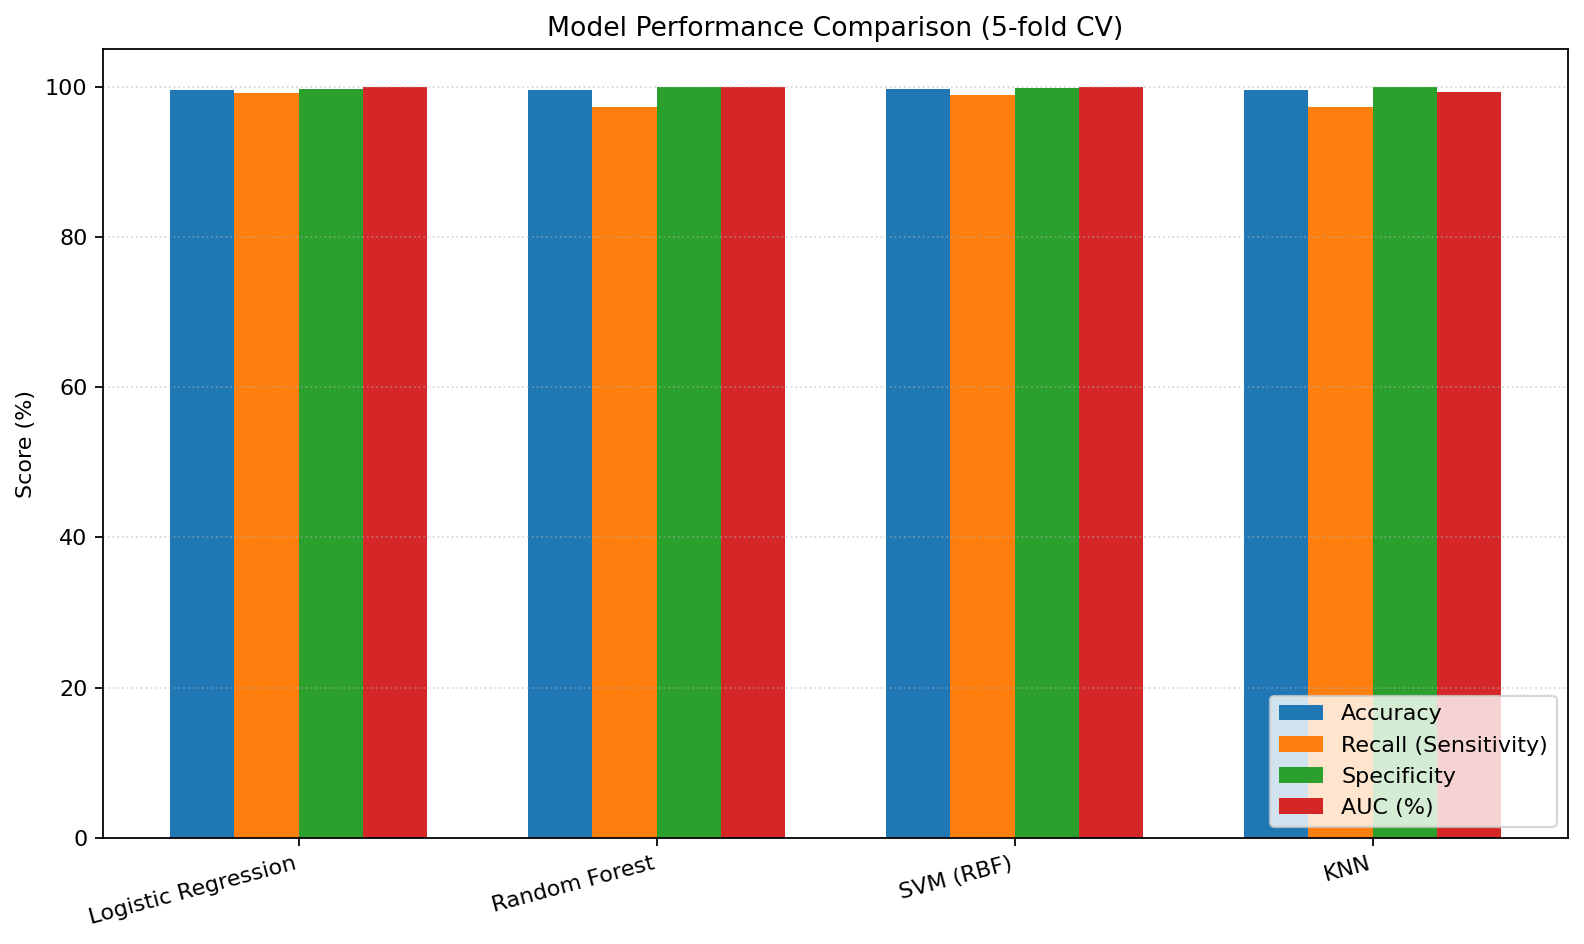

Saved: performance_comparison.png


In [7]:
# 6) Comparison graph (Accuracy, Recall, Specificity, AUC)
# -----------------------------
# Extract numeric means for plotting
plot_df = pd.DataFrame({
    "Model": [r["Model"] for r in records],
    "Accuracy": [r["_acc_mean"] for r in records],
    "Recall":   [r["_rec_mean"] for r in records],
    "Specificity": [r["_spec_mean"] for r in records],
    "AUC":      [r["_auc_mean"] for r in records],
})

fig, ax = plt.subplots(figsize=(10,6), dpi=160)

bar_w = 0.18
x = np.arange(len(plot_df))

ax.bar(x - 1.5*bar_w, plot_df["Accuracy"]*100, width=bar_w, label="Accuracy")
ax.bar(x - 0.5*bar_w, plot_df["Recall"]*100,   width=bar_w, label="Recall (Sensitivity)")
ax.bar(x + 0.5*bar_w, plot_df["Specificity"]*100, width=bar_w, label="Specificity")
ax.bar(x + 1.5*bar_w, plot_df["AUC"]*100, width=bar_w, label="AUC (%)")

ax.set_xticks(x)
ax.set_xticklabels(plot_df["Model"], rotation=15, ha="right")
ax.set_ylabel("Score (%)")
ax.set_title("Model Performance Comparison (5-fold CV)")
ax.grid(axis='y', linestyle=':', alpha=0.5)
ax.legend(loc="lower right")

plt.tight_layout()
plt.savefig("performance_comparison.png", dpi=300)
plt.show()
print("Saved: performance_comparison.png")


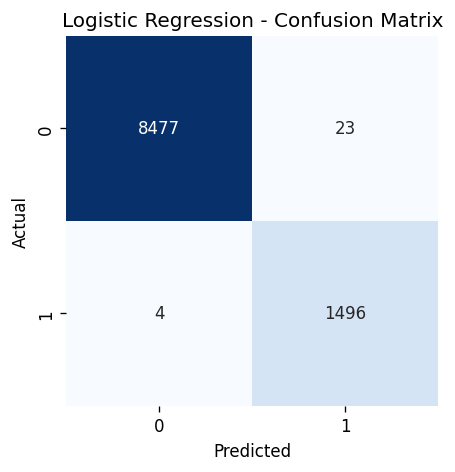

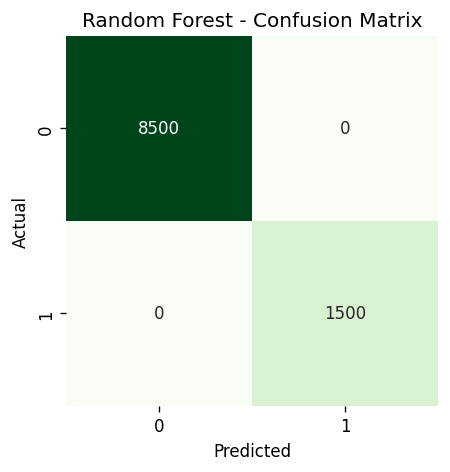

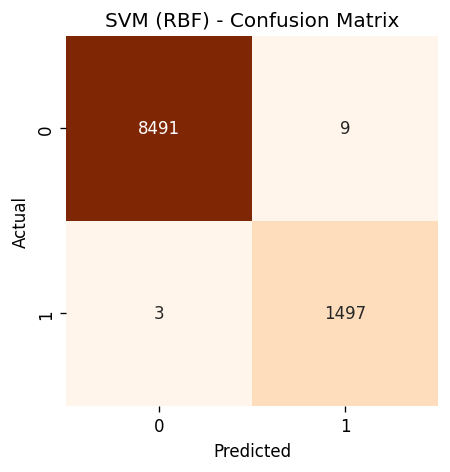

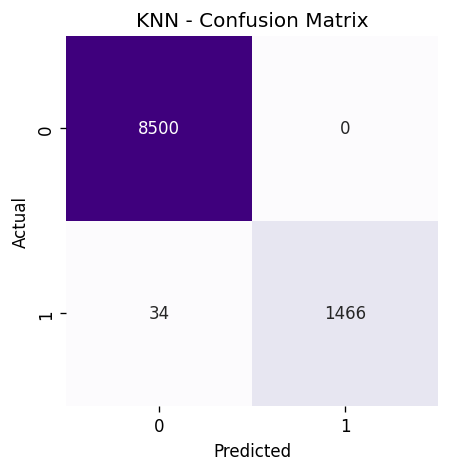

In [10]:
# === Confusion Matrices for Logistic Regression, SVM, Random Forest, and KNN (different colors) ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# Define models with unique colormaps
models = {
    "Logistic Regression": (LogisticRegression(max_iter=5000, class_weight='balanced'), "Blues"),
    "Random Forest": (RandomForestClassifier(n_estimators=400, class_weight='balanced', random_state=42), "Greens"),
    "SVM (RBF)": (SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42), "Oranges"),
    "KNN": (KNeighborsClassifier(n_neighbors=5), "Purples")
}

# Train on full dataset and show confusion matrices
for name, (clf, cmap) in models.items():
    pipe = Pipeline([("prep", preprocessor), ("clf", clf)])
    pipe.fit(X, y)  # fit on entire dataset
    preds = pipe.predict(X)

    cm = confusion_matrix(y, preds)
    plt.figure(figsize=(4,4), dpi=120)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [8]:
# 7) Pick best two models and show overall confusion matrices
#    (based on highest F1, then Accuracy)
# -----------------------------
# Rank by mean F1 (we stored F1 in display-only string; recompute quickly from plot_df and records)
rank_df = pd.DataFrame({
    "Model": [r["Model"] for r in records],
    "F1":    [float(r["F1-Score"].split("±")[0]) for r in records],
    "ACC":   [r["_acc_mean"] for r in records]
}).sort_values(by=["F1","ACC"], ascending=False)

top_models = rank_df["Model"].tolist()[:2]

for m in top_models:
    y_pred_all = oof_predictions[m]
    tn, fp, fn, tp = confusion_matrix(y, y_pred_all).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    rec = tp/(tp+fn) if (tp+fn)>0 else 0
    spec = tn/(tn+fp) if (tn+fp)>0 else 0
    print(f"\nConfusion Matrix (OOF) for {m}:")
    print(pd.DataFrame([[tn, fp],[fn, tp]],
                       index=["Actual 0 (Benign)","Actual 1 (Malignant)"],
                       columns=["Pred 0","Pred 1"]))
    print(f"Accuracy={acc*100:.2f}%, Recall={rec*100:.2f}%, Specificity={spec*100:.2f}%")


Confusion Matrix (OOF) for SVM (RBF):
                      Pred 0  Pred 1
Actual 0 (Benign)       8488      12
Actual 1 (Malignant)      16    1484
Accuracy=99.72%, Recall=98.93%, Specificity=99.86%

Confusion Matrix (OOF) for KNN:
                      Pred 0  Pred 1
Actual 0 (Benign)       8500       0
Actual 1 (Malignant)      40    1460
Accuracy=99.60%, Recall=97.33%, Specificity=100.00%
